#library

In [1]:
import pandas as pd
from pandas.core.frame import DataFrame

import numpy as np

import requests
import regex as re

import random

import nltk
from nltk.corpus import gutenberg,stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import feature_extraction, manifold
from sklearn import decomposition

import gensim
import gensim.downloader as gensim_api
from gensim.corpora import Dictionary

import warnings
warnings.filterwarnings(action='once')

from sklearn.manifold import TSNE




In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
#word ebbedding dictionnary, takes about 1-4 mins(376 MB)
nlp = gensim_api.load("glove-wiki-gigaword-100") 

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


### Data Partitioning

#### ```partition()``` Devides the words list into 200 samples of 150 words each 

In [4]:
def partition(words, book_label):
  n = len(words) // 150  # How many 150-word partitions are there?
  partitions =[]
  i = 0

  # Loop over the words to store each 150-word partition in a list inside partitions list
  while i < n:
    current = i*150
    partitions.append([words[current:current+150], book_label])
    i+=1


  # return a dataframe of 200 samples
  return DataFrame(partitions[:200], columns = ['words', 'Book_name'])


In [5]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

####``` data_preperation ``` returns a clean list of words from a single book







In [6]:
stop_words = stopwords.words('english')
def data_preperation (url):
  #Getting data
  response = requests.get(url)
  text =response.text.lower()


  #Data cleansing:
  text = re.sub('[^a-z]+', ' ', text)

  # p = re.compile(r'\W+')
  # words = p.split(text)

  #Part of spech:
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

  lemmatizer  = WordNetLemmatizer()
  #lemmatized = [lemmatizer.lemmatize(wrd[0], pos =  wrd[1]) for wrd in wordnet_tagged if wrd[1]!=None and wrd not in stop_words]
  lemmatized_words = []
  for wrd in wordnet_tagged:
     #loop over the words and thier part of spech to lemmatize them
    if wrd[1]!= None and wrd[0] not in stop_words :
      if wrd[0][-3:] == 'ing': #to lemmatize a word even if it's a noun
        pos = 'v'
      else:
        pos =  wrd[1]
      #final = lemmatizer.lemmatize(wrd[0], pos =  pos)
      if lemmatizer.lemmatize(wrd[0], pos =  pos) in nlp.vocab.keys():
        lemmatized_words.append(lemmatizer.lemmatize(wrd[0], pos =  pos))

  # Pass the words, ignoring the first 500 to avoid introductions.. 
  return lemmatized_words[500:]

#### ``` Data_generator ```

In [7]:
def Data_generator(urls=['https://www.gutenberg.org/files/68054/68054-0.txt'], labelels = ["a"]):
  # a dataframe to store samples from all of the books
  big_frame = DataFrame() 

  for url, label in zip(urls, labelels):
    words = data_preperation(url) #returns a list of words from a single book
    x = partition(words, label) # Devides the words list into 200 samples of 100 words each
    big_frame =pd.concat([big_frame, x]) # Append book samples to the big dataframe


  return big_frame

# ``` main ```  
Passes two lists of books urls & labels to ```Data_generator```

In [147]:
#if __name__ == "__main__":
# urls = ['https://www.gutenberg.org/cache/epub/18350/pg18350.txt', #1)Social Life in the Insect World, Author: J. H. Fabre
#         'https://www.gutenberg.org/cache/epub/18931/pg18931.txt',  #2)Archeological Investigations, Author: Gerard Fowke
#         'https://www.gutenberg.org/cache/epub/13058/pg13058.txt',   #3)The Teeth of the Tiger, Author: Maurice Leblanc
#         'https://www.gutenberg.org/cache/epub/28056/pg28056.txt', #4)Music and Some Highly Musical People, Author: James M. Trotter
#         'https://www.gutenberg.org/cache/epub/21687/pg21687.txt', #)The Youngest Girl in the Fifth, Author: Angela Brazil
#         ]
urls = ['https://www.gutenberg.org/files/17321/17321-0.txt', #1)Social Life in the Insect World, Author: J. H. Fabre
        'https://www.gutenberg.org/cache/epub/22775/pg22775.txt',  #2)Archeological Investigations, Author: Gerard Fowke
        'https://www.gutenberg.org/cache/epub/10136/pg10136.txt',   #3)The Teeth of the Tiger, Author: Maurice Leblanc
        'https://www.gutenberg.org/cache/epub/28056/pg28056.txt', #4)Music and Some Highly Musical People, Author: James M. Trotter
        'https://www.gutenberg.org/cache/epub/51854/pg51854.txt', #)The Youngest Girl in the Fifth, Author: Angela Brazil
        ]
labelels = ["a", "b", "c", "d", "e"]

df = Data_generator(urls, labelels).sample(frac=1).reset_index(drop=True)

In [96]:
df

,words,Book_name
0,"[year, field, cricket, cease, sing, long, begi...",a
1,"[foot, rear, wall, cave, make, turn, foot, mou...",b
2,"[urge, long, know, look, sharp, come, fact, sp...",c
3,"[click, nothing, else, need, take, popular, mi...",a
4,"[intelligent, heartfelt, religious, faith, nee...",d
...,...,...
995,"[foot, hill, approximate, space, square, foot,...",b
996,"[overthrow, obstacle, shoot, chief, inspector,...",c
997,"[cultivation, readily, attract, attention, nat...",d
998,"[genius, burn, brightly, soul, young, boy, cle...",d


#Data Transformers

### BOW

In [148]:
paragraph=" "
paragraph_list=[]
for x in df['words']:
    paragraph=paragraph.join(x) 
    paragraph_list.append(paragraph)
    paragraph=" "
#paragraph_list =paragraph_list + paragraph_list
len(paragraph_list)

1000

In [149]:
def BOW(sentences_book):
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(sentences_book).toarray()
  
  return X_train_counts

###TF-IDF

In [150]:
def TF_IDF(X_train_counts):
  tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
  X_train_tf = tf_transformer.transform(X_train_counts).toarray()
  
  return X_train_tf

###LDA

In [151]:
dictionary = Dictionary(df['words'])
bow_ = [dictionary.doc2bow(partition) for partition in df['words']]  # bag of words for each partition
example = pd.DataFrame(bow_[10], columns=["token_id", "frequency"])

def lda_training(n_topics, dictionary):
  lda_model = gensim.models.LdaModel(bow_,
               id2word = dictionary,
               num_topics = n_topics,
               random_state = 100,
               passes = 50,
               iterations = 500, 
               chunksize = 100
               )
  coherence_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=df['words'], dictionary=dictionary , coherence='c_v')
  coherence_lda = coherence_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)
  print(lda_model.print_topics())
  return lda_model

In [152]:
lda1 = lda_training(n_topics = 10,dictionary = dictionary)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Coherence Score:  0.5886125918386402
[(0, '0.029*"god" + 0.016*"stone" + 0.015*"gudea" + 0.013*"mistress" + 0.009*"dinner" + 0.009*"roll" + 0.008*"servant" + 0.008*"sign" + 0.008*"build" + 0.007*"pound"'), (1, '0.011*"temple" + 0.010*"great" + 0.007*"time" + 0.007*"miss" + 0.007*"find" + 0.007*"tomb" + 0.006*"work" + 0.006*"give" + 0.006*"begin" + 0.006*"late"'), (2, '0.011*"case" + 0.010*"certain" + 0.009*"movement" + 0.009*"disease" + 0.008*"personality" + 0.008*"large" + 0.008*"point" + 0.008*"impulse" + 0.008*"condition" + 0.007*"view"'), (3, '0.027*"king" + 0.022*"dynasty" + 0.016*"early" + 0.013*"egyptian" + 0.013*"find" + 0.013*"period" + 0.010*"egypt" + 0.009*"semitic" + 0.008*"babylonian" + 0.008*"city"'), (4, '0.012*"make" + 0.006*"sauce" + 0.005*"carve" + 0.005*"pudding" + 0.005*"object" + 0.005*"roast" + 0.005*"cream" + 0.005*"lie" + 0.005*"general" + 0.004*"white"'), (5, '0.021*"music" + 0.013*"musical" + 0.009*"great" + 0.009*"voice" + 0.009*"give" + 0.009*"mr" + 0.008*"

In [153]:
def feature_vectorize(lda):

  # Convert target column from string to numbers 
  df.Book_name = pd.Categorical(df.Book_name)
  df['Book_name'] = df.Book_name.cat.codes

  
  train_vecs = []
  for i in range(len(df['words'])):
    top_topics = lda.get_document_topics(bow_[i], minimum_probability = 0.0)
    topic_vec = [top_topics[i][1] for i in range(len(lda.print_topics()))]
    train_vecs.append(topic_vec)

  features = pd.DataFrame(train_vecs)
  lda_data = features.join(df["Book_name"])#.sample(frac = 1)

  lda_x = lda_data[lda_data.columns[:-1]]
  lda_y = pd.DataFrame(lda_data[lda_data.columns[-1]])
  return lda_data, lda_x, lda_y

###Word Embedding

In [154]:
def word_embidding():
  reduction = []
  for i in range(0, 1000):
    #transform each word to a vec
    doc2vec = nlp[df['words'].iloc[i]]

    #reduce the dimensions from 300 to 2
    pca = decomposition.PCA(n_components=50)
    reduction.append(doc2vec)

  we_array = np.array(reduction).reshape(1000, 100*150)  
  return pd.DataFrame(we_array)

## Implement transformations 

In [155]:
X_train_counts= BOW(paragraph_list)
X_train_tf= TF_IDF(X_train_counts)
# x_train_ngram=Ngram(paragraph_list)
lda_data, lda_x, lda_y = feature_vectorize(lda1)
X_train_we = word_embidding()

In [156]:
lda_x

,0,1,2,3,4,5,6,7,8,9
0,0.000662,0.909898,0.000662,0.065942,0.000662,0.000662,0.000662,0.011337,0.008849,0.000663
1,0.000662,0.018020,0.000662,0.000662,0.010916,0.017748,0.038639,0.133460,0.027439,0.751791
2,0.000662,0.153891,0.000662,0.000662,0.593538,0.189062,0.000662,0.059534,0.000662,0.000662
3,0.000662,0.000662,0.000662,0.000662,0.332429,0.000662,0.662272,0.000662,0.000662,0.000662
4,0.000662,0.031851,0.081891,0.095433,0.000662,0.000662,0.361710,0.251517,0.000663,0.174949
...,...,...,...,...,...,...,...,...,...,...
995,0.020869,0.000662,0.000662,0.000662,0.746379,0.000662,0.192691,0.000662,0.000662,0.036088
996,0.028492,0.067897,0.000662,0.019942,0.000662,0.072175,0.128593,0.297144,0.025593,0.358839
997,0.000662,0.367642,0.000662,0.422393,0.102935,0.020348,0.000662,0.051364,0.032669,0.000662
998,0.039561,0.092742,0.011906,0.008703,0.000662,0.023497,0.064340,0.522702,0.000662,0.235224


In [157]:
lda_x

,0,1,2,3,4,5,6,7,8,9
0,0.000662,0.909898,0.000662,0.065942,0.000662,0.000662,0.000662,0.011337,0.008849,0.000663
1,0.000662,0.018020,0.000662,0.000662,0.010916,0.017748,0.038639,0.133460,0.027439,0.751791
2,0.000662,0.153891,0.000662,0.000662,0.593538,0.189062,0.000662,0.059534,0.000662,0.000662
3,0.000662,0.000662,0.000662,0.000662,0.332429,0.000662,0.662272,0.000662,0.000662,0.000662
4,0.000662,0.031851,0.081891,0.095433,0.000662,0.000662,0.361710,0.251517,0.000663,0.174949
...,...,...,...,...,...,...,...,...,...,...
995,0.020869,0.000662,0.000662,0.000662,0.746379,0.000662,0.192691,0.000662,0.000662,0.036088
996,0.028492,0.067897,0.000662,0.019942,0.000662,0.072175,0.128593,0.297144,0.025593,0.358839
997,0.000662,0.367642,0.000662,0.422393,0.102935,0.020348,0.000662,0.051364,0.032669,0.000662
998,0.039561,0.092742,0.011906,0.008703,0.000662,0.023497,0.064340,0.522702,0.000662,0.235224


#Clustering Models

*inputs*: 

X_train_counts, X_train_tf, lda_x, X_train_we

In [158]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import cohen_kappa_score
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.cluster import homogeneity_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import GenericUnivariateSelect, chi2

In [159]:
def selection(x,y):
  transformer = GenericUnivariateSelect(chi2, mode='k_best', param=1000)
  return transformer.fit_transform(x,y)

In [160]:
def change_scaling(feature_data):

  scaler = MinMaxScaler()
  scaler.fit(feature_data)
  new_data=scaler.transform(feature_data)
  return new_data

In [161]:
#determine optimal number of clusters
def get_no_clusters(feature_data):
  wcss = []
  for i in range(1, 11):
      kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
      kmeans.fit(feature_data)
      wcss.append(kmeans.inertia_)
      
  plt.plot(range(1, 11), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
  
  s = []
  for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(feature_data)
    s.append(silhouette_score(feature_data, kmeans.labels_))

  plt.plot(range(2, 11), s)
  plt.xlabel('Number of clusters')
  plt.ylabel('silhouette')
  plt.show()
  clear_output

  plt.bar(range(2, 11), s)
  plt.xlabel('Number of Clusters')
  plt.ylabel('V-Measure Score')
  plt.title('Comparison of different Clustering Models')
  plt.show()

In [162]:
def k_mean_model(feature_data,k):

  #apply k_means
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=30, random_state=100)
  model=kmeans.fit(feature_data)
  pred_y = kmeans.predict(feature_data)
  return pred_y,model

In [163]:
def plot_kmeans(feature_data,title):
  
  #PCA
  pca = PCA(n_components=2)
  new_feature=pca.fit_transform(feature_data)

  kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=100)
  model=kmeans.fit(new_feature)
  pred_y = kmeans.predict(new_feature)

  #build dataframe
  new_df=pd.DataFrame()
  x_list=[]
  y_list=[]
  for i in new_feature:
    x_list.append(i[0])
    y_list.append(i[1])

  new_df['x']=pd.DataFrame(x_list)
  new_df['y']=pd.DataFrame(y_list)
  new_df['label']=pd.DataFrame(pred_y)
  
  #plot_seaborn
  sns.scatterplot(data=new_df,x=new_df.iloc[:,0],y=new_df.iloc[:,1],s=120,hue=new_df['label'])
  plt.title(f'K_MEAN WITH {title}')
  sns.scatterplot(x=kmeans.cluster_centers_[:, 0],y=kmeans.cluster_centers_[:, 1],s=150,color='y')
  

In [164]:
def compare_target(y_pred):

  compare_df = pd.concat([df, pd.DataFrame(y_pred, columns = ['predicted'])], axis=1)
  for i in range(5):
    predicted_class = compare_df[compare_df['Book_name'] == i].predicted.mode()[0]
    compare_df["predicted"] = compare_df.predicted.replace(predicted_class, i)
  return compare_df["predicted"].to_numpy()

#coherence

In [165]:
def joinDocPartitions(text_df, groupby_col):
    doc_labels = sorted(text_df[groupby_col].unique())
    docs = []
    for i, label in enumerate(doc_labels):
        doc_text = text_df[text_df[groupby_col] == label]
        text = ' '.join(doc_text["document"].values)
        docs.append(text)
    return docs

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

def getMostFreqWordsText(text_df, n_words, groupby_col):
  '''Accepts df with text partitions unlinke
      getMostFreqWords function that needs
      BOW or TFIDF encoded df'''
  docs = joinDocPartitions(text_df, groupby_col)
  freq_terms = []
  for doc in docs:
    vectorizer = CountVectorizer(max_features=n_words)
    vectorizer.fit([doc])
    vocab = vectorizer.get_feature_names()
    freq_terms.append(vocab)
  return freq_terms

In [167]:
# centroid_colname -> the name of target column
# df_pred          -> dataFrame of two columns the first is the documents(original documents) and the second column is the prediction of em model

from itertools import combinations

def compute_coherence(df_pred, w2v_model, centroid_colname = "pred", top_n=20):
  word_freqs_list = getMostFreqWordsText(df_pred, top_n, centroid_colname)

  coherences = []
  for i in range(len(word_freqs_list)):
    freq_words = word_freqs_list[i]
    topic_similarity = []
    for word_i, word_j in combinations(freq_words, 2):
      try:
        topic_similarity.append(w2v_model.wv.similarity(word_i, word_j))
      except:
        pass
        #print(f"Niether {word_i} nor {word_j} is in vocab, skipping")
    avg_similarity = sum(topic_similarity) / len(topic_similarity)
    coherences.append(avg_similarity)
  return sum(coherences)/len(coherences)


In [168]:
# slice document into words
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['document'].iteritems():
        word_list = sentence[1].split()
        corpus.append(word_list)
          
    return corpus

#evaluate

In [169]:
x=df['Book_name'].to_numpy()
def evaluate_model(model,feature_data,pred_y):
  print(f'the silhouette_score = {silhouette_score(feature_data,pred_y)}')
  print(f'the Kappa_score = {cohen_kappa_score(x,pred_y)}')
  #print(f'the homogeneity_score = {homogeneity_score(x,pred_y)}')  


#k-mean with BOW 

In [174]:
# #X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(X_train_counts)
y_pred,model=k_mean_model(X_train_counts,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}')  
y_pred=compare_target(y_pred)
evaluate_model(model,X_train_counts,y_pred)
#plot_kmeans(X_train_counts," BOW")

the homogeneity_score = 0.8859595020424447
the silhouette_score = 0.007331005636631517
the Kappa_score = 0.41874999999999996


In [ ]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

#k-mean with tf_idf

In [173]:
#X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(X_train_tf)
y_pred,model=k_mean_model(X_train_tf,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}') 
y_pred=compare_target(y_pred)
evaluate_model(model,X_train_tf,y_pred)
#plot_kmeans(X_train_tf,"TF-IDF")

the homogeneity_score = 0.8919615807392156
the silhouette_score = 0.029906373268104167
the Kappa_score = 0.42125


In [ ]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

#k_mean with lda_x

In [172]:
#X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(lda_x)
y_pred,model=k_mean_model(lda_x,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}') 
y_pred=compare_target(y_pred)
evaluate_model(model,lda_x,y_pred)
#plot_kmeans(lda_x,"LDA")

the homogeneity_score = 0.8544021455321142
the silhouette_score = 0.3829900026321411
the Kappa_score = 0.73


In [ ]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

#k_mean with X_train_we

In [171]:
#X_train_counts, X_train_tf, lda_x, X_train_we
#get_no_clusters(X_train_we)
y_pred,model=k_mean_model(X_train_we,5)
print(f'the homogeneity_score = {homogeneity_score(x,y_pred)}')
y_pred=compare_target(y_pred)
evaluate_model(model,X_train_we,y_pred)
#plot_kmeans(X_train_we,"word Embedding")

the homogeneity_score = 0.7761638470473962
the silhouette_score = -0.00944028701633215
the Kappa_score = 0.6425000000000001


In [ ]:
#compute coherence
cdf = DataFrame()
cdf['document'] = df.words
cdf.document = cdf.document.apply(lambda x:' '.join(x))
cdf['pred'] =y_pred

# df -> the original dataframe which contains the text documents and the titles
from gensim.models import Word2Vec
corpus = build_corpus(cdf)        
w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)
print(f'the coherence score of k mean is {compute_coherence(cdf,w2v_model)}')

#Visualizations:

/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


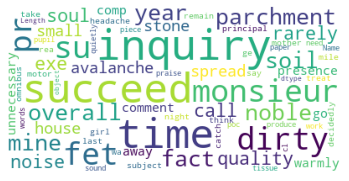

In [78]:
import wordcloud
import matplotlib.pyplot as plt
wc=wordcloud.WordCloud(background_color='white',max_words=100,max_font_size=50)
wc=wc.generate(str(df['words']))
fig=plt.figure(num=1)
plt.axis('off')
plt.imshow(wc,cmap=None)
plt.show()

<Figure size 432x288 with 0 Axes>

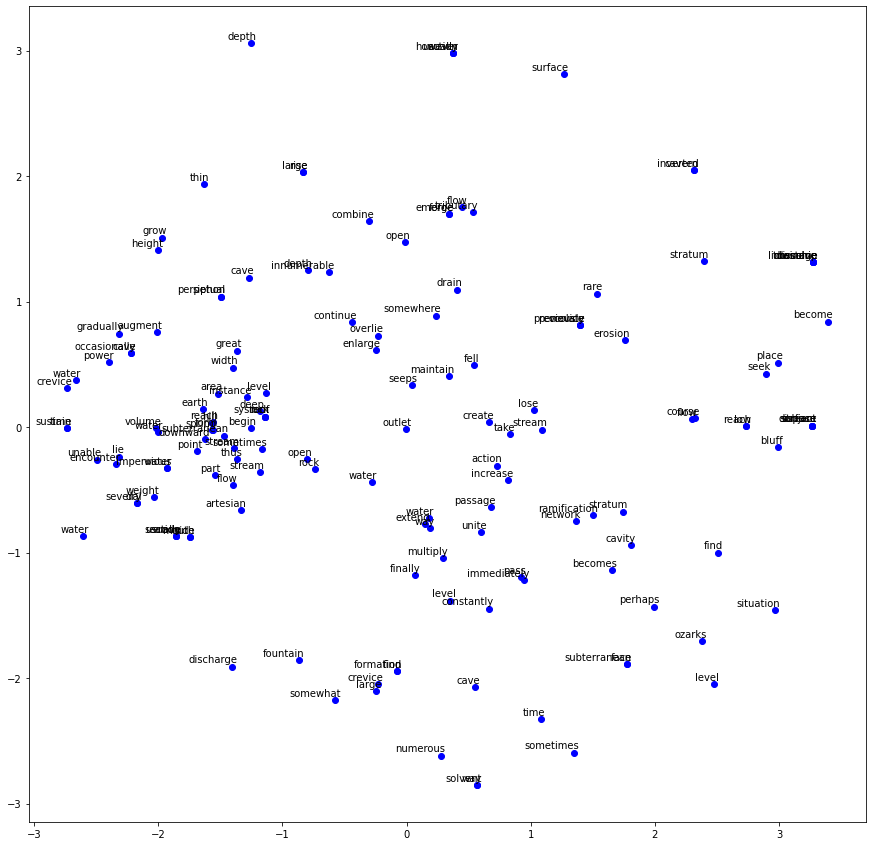

In [79]:
#Word Embedding:

doc2vec = nlp[df['words'].iloc[0]]
# pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
pca = decomposition.PCA(n_components=2)
reduction = pca.fit_transform(doc2vec)
reduction.shape

labels, X, x, y = [], [], [], []
for value in reduction:
    x.append(value[0])
    y.append(value[1])
## plot

for t in range(0, 150):
    X.append(reduction[t])
    labels.append(df['words'].iloc[5][t])

fig = plt.figure()
plt.figure(figsize=(15,15))
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="blue")
    
    plt.annotate(labels[i], 
                 xy=(x[i],y[i]), 
                 xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')

In [80]:
%pip install pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda1, bow_, dictionary=dictionary)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 21.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=9f2cd4db54e2b61c88b5eec77eec2fcd73eb5ec29a9ebea8e152d4edfce6f2b3
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/funcy-1.17.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/pyLDAvis-3.3.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.080511  0.214782       1        1  35.814093
3      0.303320  0.052094       2        1  14.984120
9     -0.169102  0.177736       3        1  10.639814
1      0.090027  0.058090       4        1   8.651245
5      0.073561  0.005334       5        1   7.209230
6     -0.207859  0.063158       6        1   7.113683
7      0.056460 -0.187214       7        1   6.196123
0     -0.144557  0.014120       8        1   4.683587
8     -0.055810 -0.222459       9        1   3.338776
2     -0.026553 -0.175643      10        1   1.369328, topic_info=            Term         Freq        Total Category  logprob  loglift
746         foot  1031.000000  1031.000000  Default  30.0000  30.0000
1165        gwen   662.000000   662.000000  Default  29.0000  29.0000
548         cave   864.000000   864.000000  Default  28.0000  28.0000
168           go   647.000000   647.000000  Default  27.0000  27.0000
89           say   830.000000   830.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2739       piece    13.924428   146.588439  Topic10  -4.9939   1.9369
1312        mass    10.748102    69.706088  Topic10  -5.2528   2.4213
128   appearance    10.619079    81.867009  Topic10  -5.2649   2.2484
972        rapid     9.318181    26.496248  Topic10  -5.3956   3.2458
1553    progress     9.294474    24.956467  Topic10  -5.3981   3.3031

[566 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
916       7  0.976275  abdomen
997       4  0.981336  ability
4105      9  0.957939  absence
2843      1  0.975930  account
2843      9  0.011758  account
...     ...       ...      ...
4776      4  0.975932     york
1461      1  0.326526    young
1461      4  0.448024    young
1461      6  0.113904    young
1461      7  0.113904    young

[859 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 10, 2, 6, 7, 8, 1, 9, 3])